In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.lib.recfunctions import append_fields
from params import *
from process_datasets import *
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

In [2]:
all_features = ['articulation_feature.kor', 'asynchrony_feature.delta', 'asynchrony_feature.pitch_cor', 'asynchrony_feature.vel_cor', 'asynchrony_feature.voice_std', 
                'dynamics_feature.agreement', 'dynamics_feature.consistency_std', 'dynamics_feature.ramp_cor', 'dynamics_feature.tempo_cor', 
                'pedal_feature.onset_value', 'pedal_feature.offset_value', 'pedal_feature.to_prev_release', 'pedal_feature.to_next_release', 
                'pedal_feature.average_pedal', 'pedal_feature.pedal_coverage']

In [5]:
def plot_by_dataset(dataset="ASAP", attri="articulation_feature.kor", level="piece", col="composer", hue=None, filter=None):
    """plot the overall distribution of each attributes from the dataset. 
    load the performance features as numpy structured array list, with optional metadata.

    Args:
        dataset (str): dataset to use. Defaults to "ASAP".
    """

    pf, meta_dict = load_dataset_pf(datasets=[dataset], return_metadata=True)
    
    if level == "piece":
        # get piece-level attributes and append the metadata
        pf_piece_concat = pd.concat([pd.DataFrame(feats).mean().to_frame().T for feats in pf], ignore_index=True)
        pf_piece_concat['composer'] = meta_dict['composer']
        pf_piece_concat['performer'] = meta_dict['performer']
        pf_plot_data = pf_piece_concat
    elif level == "note":
        pf = [pd.DataFrame(feats) for feats in pf]
        for i, feats in enumerate(pf):
            feats['composer'] = meta_dict['composer'][i]
            feats['performer'] = meta_dict['performer'][i]
        pf_note_concat = pd.concat(pf, ignore_index=True)
        pf_plot_data = pf_note_concat  

    if dataset == "ASAP" and (isinstance(filter, list)):
        for item in filter:
            pf_plot_data = pf_plot_data[pf_plot_data['composer'] != item]

    sns.set_style("darkgrid")

    g = sns.FacetGrid(pf_plot_data, col=col, col_wrap=4)
    g.map(sns.histplot, attri, stat="probability", common_norm=False, bins=20)
    g.fig.subplots_adjust(top=0.9)
    # g.fig.suptitle(f"{dataset} dataset distribution of {attri} by composer, {level} level", fontsize=16)

def plot_datasets(datasets=["ASAP", "VIENNA422", "BMZ"], attri="articulation_feature.kor", level="piece", 
                  selected_hue=[],
                  pf=None, meta_dict=None):
    """plot the overall distribution of each attributes from the datasets. 
    load the performance features as numpy structured array list, with optional metadata.

    Args:
        datasets (list): datasets to use. Defaults to ["ASAP"].
    """
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.rcParams['font.size'] = 16
    sns.set_style("darkgrid")

    for dataset, c in zip(datasets, sns.color_palette()):

        if type(pf) == None: # load if given
            pf, meta_dict = load_dataset_pf(datasets=[dataset], return_metadata=True)

        if dataset == "ATEPP":
            pf = np.array(pf)
            pf_mask = np.array([feats.shape == () for feats in pf])
            pf_piece_concat = pd.concat([pd.DataFrame(feats.item()['features']).mean().to_frame().T 
                                        for feats in pf[pf_mask]], ignore_index=True)
            pf_piece_concat['composer'] = np.array(meta_dict['composer'])[pf_mask]
            pf_piece_concat['performer'] = np.array(meta_dict['performer'])[pf_mask]
            # map the composer to only the last name
            pf_piece_concat['composer'] = pf_piece_concat['composer'].apply(lambda x: x.split("_")[-1])
        else:
            # get piece-level attributes and append the metadata
            pf_piece_concat = pd.concat([pd.DataFrame(feats.item()['features']).mean().to_frame().T 
                                        for feats in pf if (feats.shape == ())], ignore_index=True)
            pf_piece_concat['composer'] = meta_dict['composer']
            pf_piece_concat['performer'] = meta_dict['performer']      

        pf_plot_data = pf_piece_concat

        pf_piece_concat['hue'] = pf_piece_concat["composer"]
        if (dataset == "ASAP" or dataset == 'ATEPP') and selected_hue:
            # set different hue for ASAP
            pf_piece_concat['hue'] = 'others'
            composer_filter = pf_piece_concat["composer"].str.contains("|".join(selected_hue)).values.tolist()
            pf_piece_concat.loc[composer_filter, 'hue'] = pf_piece_concat.loc[composer_filter, "composer"]

        pf_plot_data = pf_plot_data.rename(columns={"f0": all_features[-2], 'f1': all_features[-1]})
        ax = sns.histplot(pf_plot_data, x=attri, 
                          hue="hue",
                        #   color=c,
                         stat='probability', common_norm=False, 
                         kde=True,
                        #  label=dataset, 
                         alpha=0.5, bins=30)
        # plt.legend()
        print(dataset, pf_plot_data[attri].mean())
        # g.fig.subplots_adjust(top=0.9)
        # g.fig.suptitle(f"{dataset} dataset distribution of {attri} by composer, {level} level", fontsize=16)


### Faster the louder, slower the softer? 

We compute the tempo-velocity correlation, which is the correlation between the tempo (inverse bp) and velocity within a N-beat window. In the default implementation we choose N=7. 

A brief inspection on the Vienna 4*22 data shows that the positive slope is relatively strong, and the tempo-dynamics coupling is more prominent in Chopin. However, for the Magdaloff and Zelinger datasets, it seems to be more negative relationships. Same with the ASAP data, 


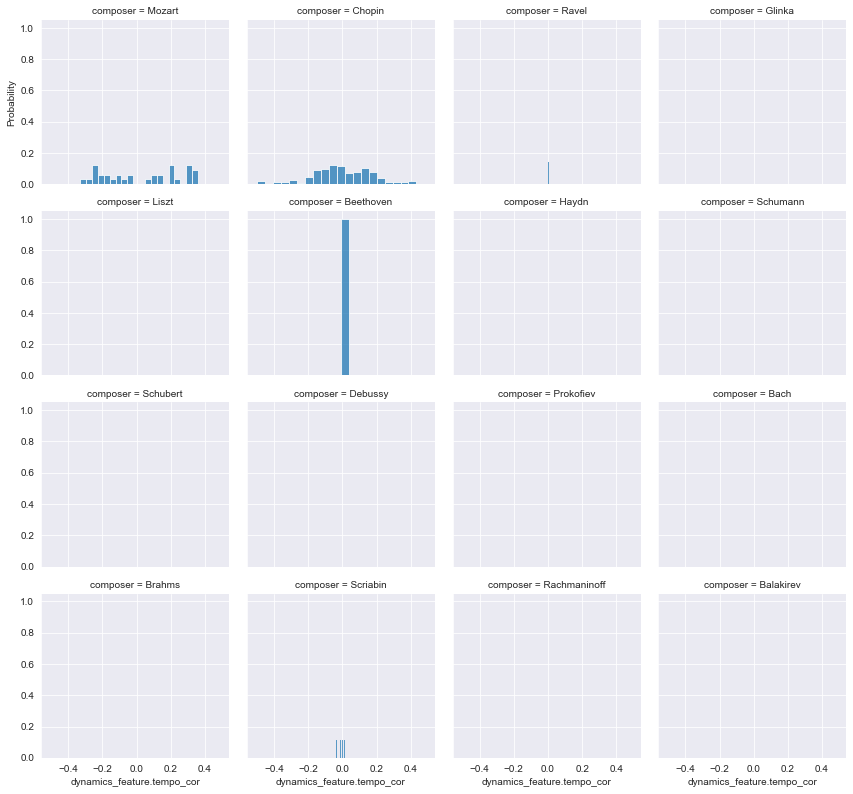

In [12]:
plot_by_dataset(dataset="ASAP", attri=all_features[8], level="piece")

##### Is the tempo-dynamics coupling more prominent within phrases? 

Suggestions: 
* loudness from velocity - at least test a small section of audio
* effect of window
* effect on voices
* Start from senario - retrieve from data

Observation from the Schubert (p13):
* smaller window shows more fluctuation but more prominent peaks as well, and majority of the time the correlation is below 0. (for w=3, mean correlation =-0.22)
* the larger the window, the higher the overall correlation
* peaks are similar for max <--> mean, but max has more significant value
* peaks are similar across windows 

Schubert (all pianists):
* common prominent place: beat 3, 69, 90
* 

[(13.0, 0.015385416), (19.5, -0.08462301), (58.0, -0.029905936), (73.5, 0.27481088)]


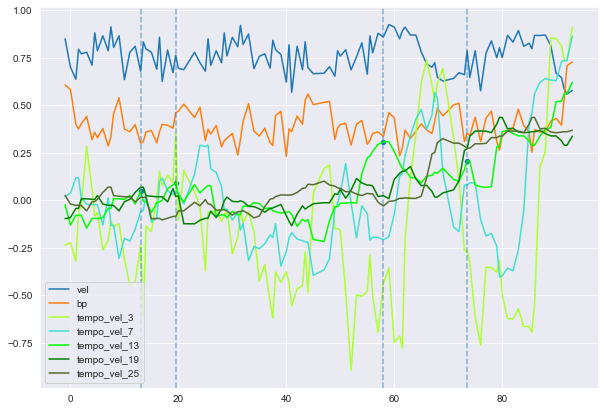

In [52]:
pianist = "p13"
score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_{pianist}.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_{pianist}.match")

agg = "max"

# m_score, unique_onset_idxs = pt.musicanalysis.compute_matched_score(score, performance, alignment)
# df = pt.musicanalysis.dynamics_feature(m_score, unique_onset_idxs, performance, w=9, agg=agg)

parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions='all')
avg_vel, m_score, unique_onset_idxs = res['avg_vel'], res['m_score'], res['unique_onset_idxs']
# # pf, meta_data = load_dataset_pf("VIENNA422", return_metadata=True)
N = len(unique_onset_idxs)
x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]

sns.lineplot(x=x, y=avg_vel / 127, label="vel")
sns.lineplot(x=x, y=parameters['beat_period'][[idxs[0] for idxs in unique_onset_idxs]], label="bp")

palette = sns.color_palette("mako_r", 6)
for window, c in zip([3, 7, 13, 19, 25], ["greenyellow", "turquoise", "lime", "green", "darkolivegreen"]):
    pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions='all', w=window)
    avg_vel = res['avg_vel']
    y = pf['dynamics_feature.tempo_cor'][[idxs[0] for idxs in unique_onset_idxs]]
    sns.lineplot(x=x, y=y, label=f"tempo_vel_{window}", color=c)
    
    if window == 13:
        peaks, _ = find_peaks(y, prominence=0.1)
        peak_timepoints = x[peaks]
        sns.scatterplot(peak_timepoints, y[peaks])
        for tm in peak_timepoints:
            plt.axvline(tm, alpha=0.5, linestyle="--")
print(list(zip(peak_timepoints, y[peaks])))

# plt.xlim(0, 80)
# plt.legend()

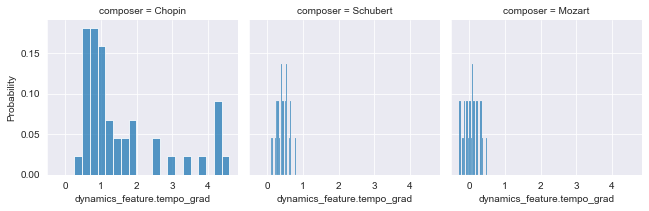

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[8], level="piece")

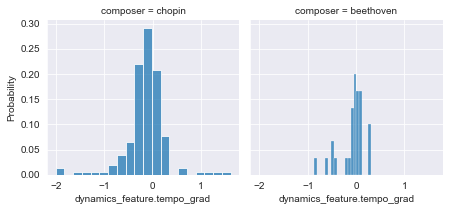

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[8])

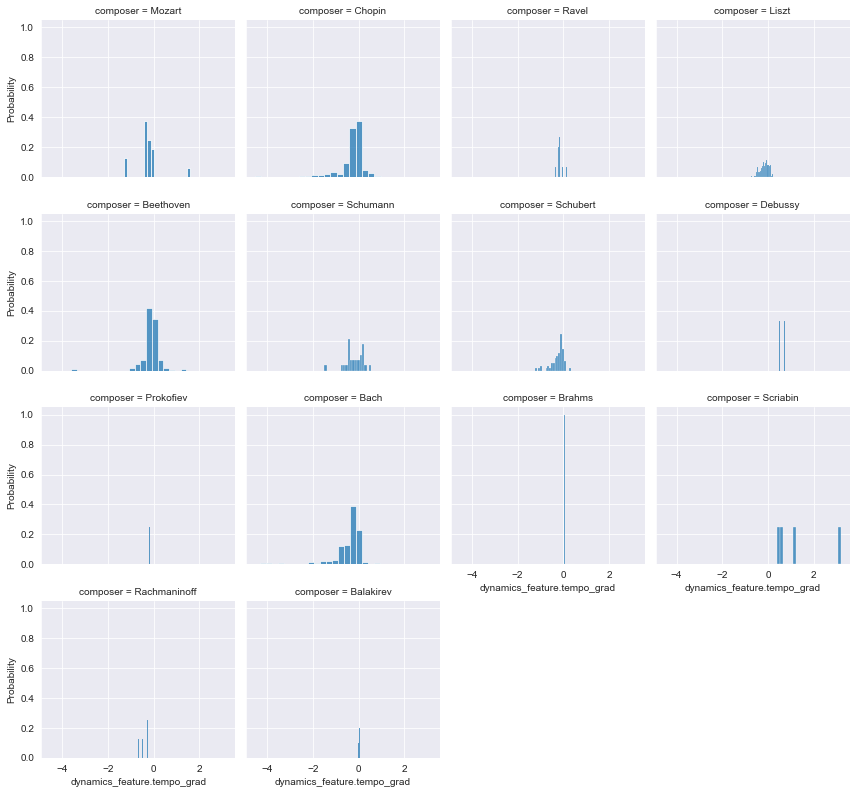

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[8], filter=['Haydn', 'Glinka'])

### How salient is Melody lead? What about bass?

Overall very strong relationship between higher pitch and earlier notes, but there is still a composition difference. Notably Bach is the one that's more evenly distributed. 

Observation in Schubert (p13):
* negative correlation peaks:  beat 9, 14, 19, 25, 31, 34, 43, 51, 72, 75. There are roughly two categories that contributes to their negative correlation: 1. No melody note on beat, so for the chord-only beat, it's the case that bass goes earlier. 2. Significant downbeat where  

In other 4*22 pieces
* Mozart: overwhelmingly on the positive side, not too much trend, the two negative places are the grace notes.
* Chopin op38: A significant increase in asynchronies when the passage slows down.
* Chopin op10: a lot of negative correlation on downbeats where there is no melody note. 

Observation cross pianists:
* Common neg-cor-peaks by averaging \ interpolating everyone: 48 (-0.26), 54 (-0.43), 72 (-0.19), 78 (-0.48). Interestingly, these corresponds with the four marcarto beat in the piece.
* The most positive place? There are two places that exhibits top correlation of 1 (agreed by all pianists!): Beat 64 and beat 88. 
<!-- 
#### Are there cases where bass is leading?

* melody lead <-> chord. But without chord maybe not. Check joint onset -> check by staff and look for the loudest note in each - if the lowest note is the loudest in the left range.  -->

[(4.0, 0.26611817), (8.0, 0.3576723), (13.0, 0.71458775), (17.0, 0.55261517), (19.0, -0.636324), (26.0, 0.82477623), (32.0, -0.6202985), (37.0, 0.5903301), (41.0, 0.8019357), (43.0, 0.6586039), (50.0, 0.57589084), (52.0, -0.24709474), (58.0, 0.007097502), (61.5, 0.24480963), (63.0, 0.34453532), (65.0, 0.8784465), (68.0, 0.042352773), (74.0, 0.5337246), (77.0, 0.40014997), (80.0, 0.6107567), (82.0, 0.6318466), (86.0, 0.3049572), (92.0, 0.74061066)]


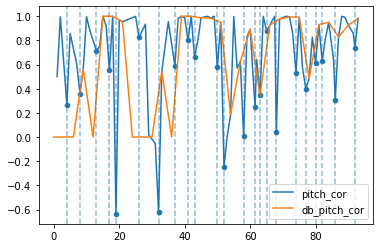

In [20]:
pianist = "p03"
score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_{pianist}.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_{pianist}.match")

pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
N = len(unique_onset_idxs)
x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
y = pf['asynchrony_feature.pitch_cor'][[idxs[0] for idxs in unique_onset_idxs]]

filtered_y = y[y != 0]
filtered_x = x[y != 0]
sns.lineplot(x=filtered_x, y=filtered_y, label="pitch_cor")

downbeat_x = x[x % 3 == 0]
downbeat_y = y[x % 3 == 0]
sns.lineplot(x=downbeat_x, y=downbeat_y, label="db_pitch_cor")

peaks, _ = find_peaks(-filtered_y, prominence=0.1)
peak_timepoints = filtered_x[peaks]
sns.scatterplot(peak_timepoints, filtered_y[peaks])
for tm in peak_timepoints:
    plt.axvline(tm, alpha=0.5, linestyle="--")

print(list(zip(peak_timepoints, filtered_y[peaks])))

# print(m_score[155:165])
# print(m_score.dtype)


[(0.25, 0.33333334), (1.0, 0.4530976), (2.0, -0.23809524), (3.0, 0.2819814), (4.0, -0.42857143), (5.0, 0.31635576), (6.0, 0.5747332), (7.0, 0.32835317), (8.0, -0.00766642), (9.0, 0.23421991), (10.0, 0.26388785), (10.75, 0.3009724), (12.0, 0.20137699), (13.0, 0.2857143), (14.0, 0.33333334), (16.0, 0.20295303), (17.0, 0.2756074), (18.0, -0.42857143), (19.25, 0.04761905), (20.0, -0.04761905), (21.0, 0.26318032), (22.0, 0.45787627), (23.0, 0.27491707), (24.0, -0.12181381), (25.25, 0.23809524), (26.75, 0.26785046), (28.0, 0.4447215), (29.0, 0.41978118), (31.0, 0.5870799), (32.0, 0.42016682), (34.75, 0.2857143), (35.5, 0.6363484), (36.0, 0.50498927), (36.5, -0.14285715), (37.75, 0.14285715), (38.75, -0.33333334), (39.5, -0.0952381)]


Text(0, 0.5, 'correlation')

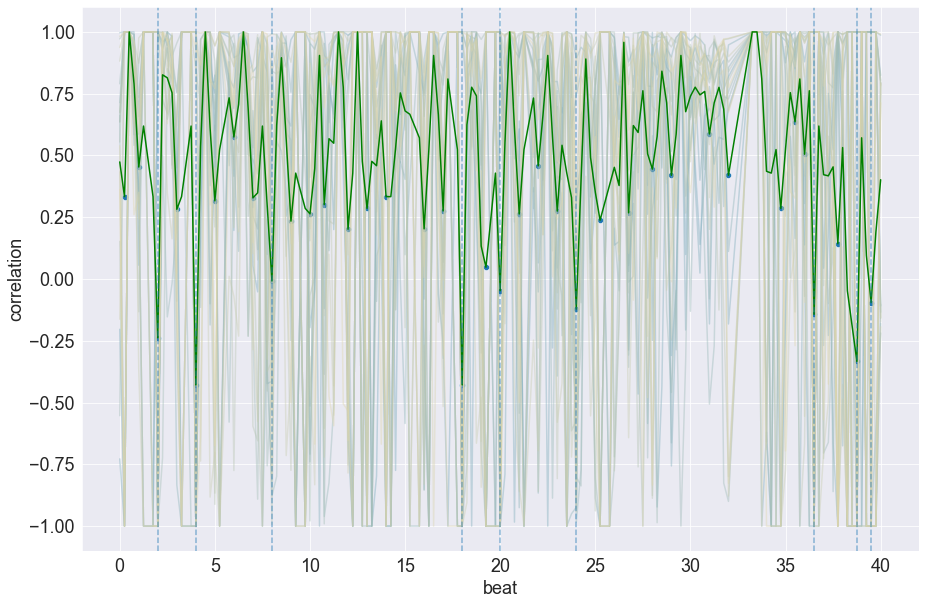

In [14]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 18

y_total = []

names = ['Schubert_D783_no15', 'Mozart_K331_1st-mov', 'Chopin_op38', 'Chopin_op10_no3']

score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Chopin_op10_no3.musicxml")
performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Chopin_op10_no3_p13.mid")
performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Chopin_op10_no3_p13.match")

pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
default_x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
# N = len(unique_onset_idxs)

colors = sns.color_palette("blend:#7AB,#EDA", as_cmap=True)
for idx, pianist in enumerate(range(1, 22)):
    pianist = str(pianist).zfill(2)
    performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Chopin_op10_no3_p{pianist}.mid")
    performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Chopin_op10_no3_p{pianist}.match")

    pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
    unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
    parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
    x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
    y = pf['asynchrony_feature.pitch_cor'][[idxs[0] for idxs in unique_onset_idxs]]

    y_interp = interp1d(x, y)(default_x)
    y_total.append(y_interp)

    filtered_y = y[y != 0]
    filtered_x = x[y != 0]
    sns.set_style("darkgrid")
    sns.lineplot(x=filtered_x, y=filtered_y, alpha=0.4, color=colors(1/22*idx))


y_total = np.array(y_total).mean(0)
filtered_y = y_total[~np.isclose(y_total, 0)]
filtered_x = default_x[~np.isclose(y_total, 0)]
sns.lineplot(x=filtered_x, y=filtered_y, alpha=1, color='green')

peaks, _ = find_peaks(-filtered_y, prominence=0.1)
peak_timepoints = filtered_x[peaks]
sns.scatterplot(peak_timepoints, filtered_y[peaks])
for peak in (peaks):
    if filtered_y[peak] < 0:
        plt.axvline(filtered_x[peak], alpha=0.5, linestyle="--")

print(list(zip(peak_timepoints, filtered_y[peaks])))
# plt.xticks(np.arange(0, 96, 3))
plt.xlabel("beat")
plt.ylabel("correlation")



### Compute the pitch correlation without the top voice

In [2]:
x_total = []
for dataset in ['ASAP']:
    alignment_paths, score_paths, performance_paths = process_dataset_pf(datasets=[dataset], 
                                                                         only_return_paths=True)
    for s_path, p_path, a_path in tqdm(zip(score_paths, performance_paths, alignment_paths)):
        if 'Chopin' not in s_path:
            continue

        score = pt.load_musicxml(s_path)

        try:
            if a_path[-3:] == "tsv":
                alignment = pt.io.importparangonada.load_alignment_from_ASAP(a_path)
                performance = pt.load_performance(p_path)
            else:
                performance, alignment = pt.load_match(a_path)

            if dataset == "ASAP": 
                score = pt.score.unfold_part_maximal(pt.score.merge_parts(score.parts)) 

            pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, 
                                                                    feature_functions=['asynchrony_feature'],
                                                                    return_articulation_mask=True)
            x = pd.DataFrame(pf['asynchrony_feature.pitch_cor'])
            x['work'] = s_path.split("/")[4]
            x_total.append(x)
        except Exception as e:
            print(a_path)
            print(e)

x_total = pd.concat(x_total, ignore_index=True)
x_total = x_total.rename(columns={0: "asynchrony_feature.pitch_cor"})


168it [03:52,  1.33s/it]

../Datasets/asap-dataset-alignment/Chopin/Sonata_2/3rd/KaszoS15_note_alignments/note_alignment.tsv
[Errno 2] No such file or directory: '../Datasets/asap-dataset-alignment/Chopin/Sonata_2/3rd/KaszoS15_note_alignments/note_alignment.tsv'


1067it [08:58,  1.98it/s]


Text(0.5, 0, 'Asynchrony pitch correlation (w/o top voice)')

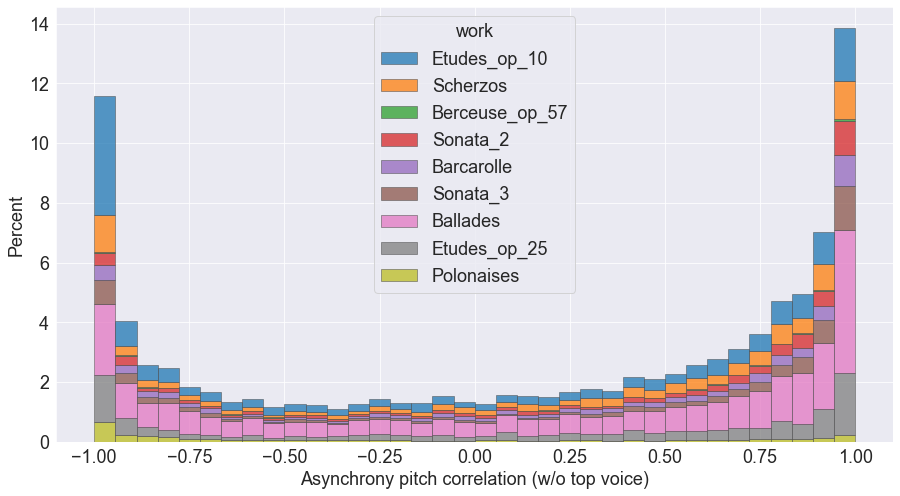

In [13]:

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 18
x_total = x_total[x_total["asynchrony_feature.pitch_cor"] != 0]
x_total = x_total[x_total["asynchrony_feature.pitch_cor"] != 1]
x_total = x_total[x_total["asynchrony_feature.pitch_cor"] != -1]

# name_list = ['Mozart', 'Chopin', 'Schumann', 'Beethoven', 'Schubert', 
#              'Bach', 'Haydn', 'Liszt'] 
# composers = [c if c in name_list else 'Others' for c in x_total['composer']]
# x_total['composer'] = composers

sns.set_style('darkgrid')
sns.histplot(
    data=x_total,
    x='asynchrony_feature.pitch_cor',
    hue="work",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    stat='percent'
)
plt.xlabel("Asynchrony pitch correlation (w/o top voice)")
# sns.displot(
#     data=x_total,
#     x="asynchrony_feature.pitch_cor", hue="work",
#     kind="kde", height=6,
#     multiple="fill", clip=(0, None),
#     palette="ch:rot=-.25,hue=1,light=.75",
# )

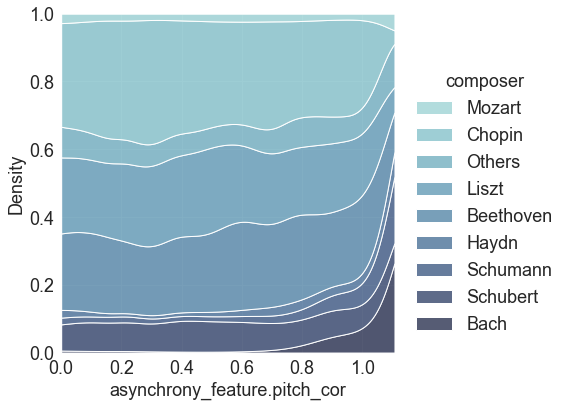

In [19]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 18

sns.set_style('darkgrid')
pf_asap, meta = load_dataset_pf(datasets=['ASAP'], return_metadata=True)
pf_note_concat_asap = pd.concat([pd.DataFrame(feats) 
                            for idx, feats in enumerate(pf_asap) if meta['composer'][]], ignore_index=True)

composers = [[meta['composer'][idx]] * len(feats) for idx, feats in enumerate(pf_asap)]
composers = [c for lc in composers for c in lc]
composers = [c if c in name_list else 'Others' for c in composers]
pf_note_concat_asap['composer'] = composers

# data = pf_note_concat_asap[~np.isclose(pf_note_concat_asap, 0)]
pf_note_concat_asap = pf_note_concat_asap[pf_note_concat_asap != 0]
pf_note_concat_asap = pf_note_concat_asap[pf_note_concat_asap != 1]
pf_note_concat_asap = pf_note_concat_asap[pf_note_concat_asap != -1]
# sns.histplot(
#     data=pf_note_concat_asap,
#     x='asynchrony_feature.pitch_cor',
#     hue="composer",
#     multiple="stack",
#     edgecolor=".3",
#     linewidth=.5,
#     stat='percent'
# )
sns.displot(
    data=pf_note_concat_asap,
    x="asynchrony_feature.pitch_cor", hue="composer",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)


### Melody lead as a velocity artifact

In [ ]:
pf_asap = load_dataset_pf(datasets=['ASAP'])
pf_piece_concat_asap = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_asap], ignore_index=True)

pf_vienna422 = load_dataset_pf(datasets=['VIENNA422'])
pf_piece_concat_vienna422 = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_vienna422], ignore_index=True)

pf_bmz = load_dataset_pf(datasets=['BMZ'])
pf_piece_concat_bmz = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_bmz], ignore_index=True)

pf_plot_data = pd.concat([pf_piece_concat_asap,
                          pf_piece_concat_vienna422,
                          pf_piece_concat_bmz], ignore_index=True)

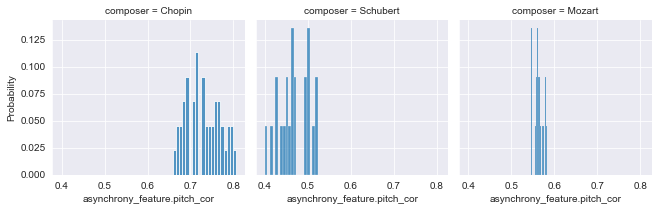

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[2], level="piece")

In [4]:
plot_by_dataset(dataset="ATEPP", attri=all_features[2], level="piece")

In [64]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [4]:
pf_atepp = load_dataset_pf(datasets=['ATEPP'])
pf_piece_concat_atepp = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_atepp], ignore_index=True)
pf_piece_concat_atepp['dataset'] = 'ATEPP'

pf_asap = load_dataset_pf(datasets=['ASAP'])
pf_piece_concat_asap = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_asap], ignore_index=True)
pf_piece_concat_asap['dataset'] = 'Others'

pf_vienna422 = load_dataset_pf(datasets=['VIENNA422'])
pf_piece_concat_vienna422 = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_vienna422], ignore_index=True)
pf_piece_concat_vienna422['dataset'] = 'Others'

pf_bmz = load_dataset_pf(datasets=['BMZ'])
pf_piece_concat_bmz = pd.concat([pd.DataFrame(feats).mean().to_frame().T 
                            for feats in pf_bmz], ignore_index=True)
pf_piece_concat_bmz['dataset'] = 'Others'

pf_plot_data = pd.concat([pf_piece_concat_atepp, 
                          pf_piece_concat_asap,
                          pf_piece_concat_vienna422,
                          pf_piece_concat_bmz], ignore_index=True)


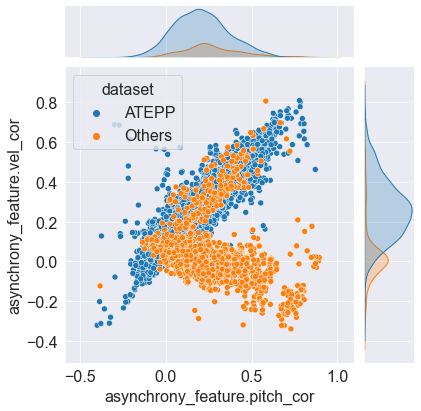

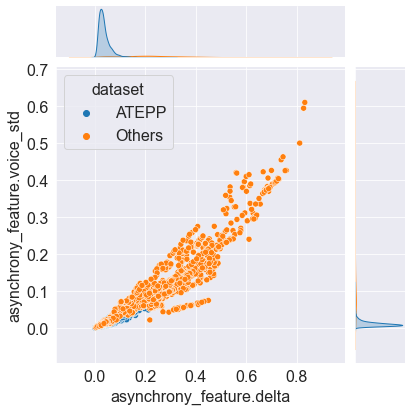

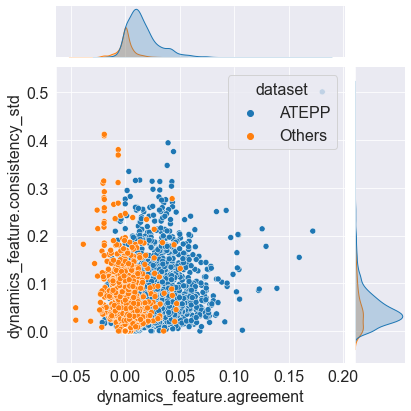

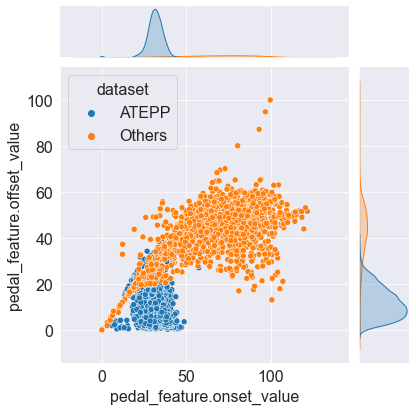

In [8]:
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
g0 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[2], y=all_features[3], hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

g1 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[1], y=all_features[4], hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

g2 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[5], y=all_features[6], hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

g3 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[0], y='articulation_log', hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

g4 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[9], y=all_features[10], hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

g5 = sns.jointplot(
    data=pf_plot_data,
    x=all_features[11], y=all_features[12], hue="dataset", marginal_kws={'common_norm':False}, palette="pastel"
)

fig = plt.figure(figsize=(24,12))
gs = gridspec.GridSpec(2, 3)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])
mg4 = SeabornFig2Grid(g4, fig, gs[4])
mg5 = SeabornFig2Grid(g5, fig, gs[5])

gs.tight_layout(fig)

plt.show()

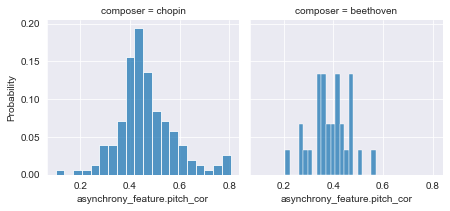

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[2], level="piece")

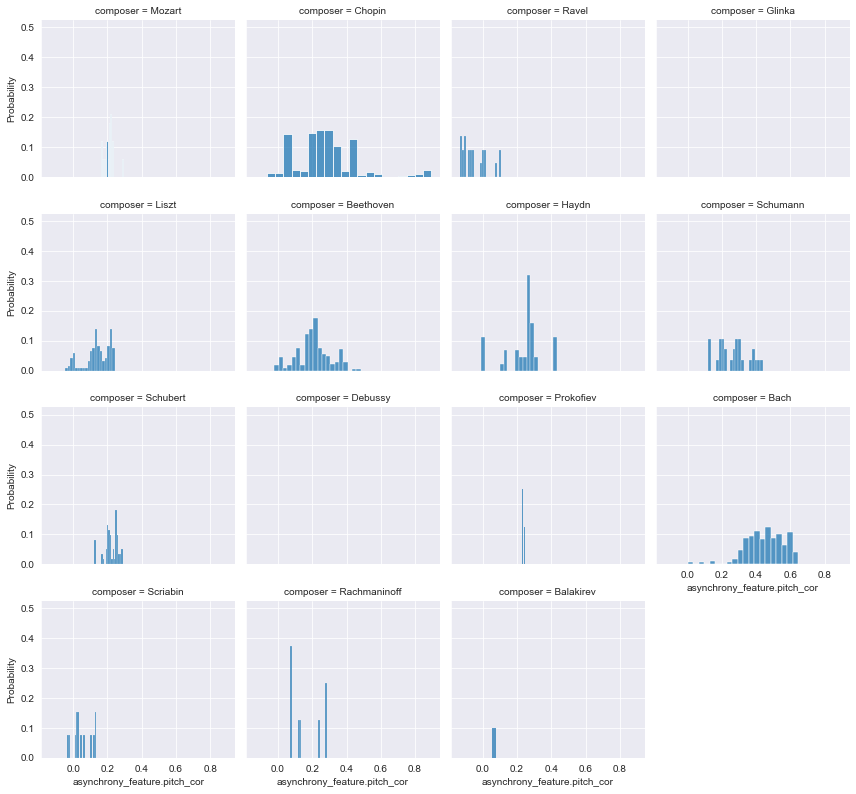

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[2], level="piece", filter=['Brahms'])

### Pedal

The release of pedal time regarding note events are measured in seconds. The to_prev_release time is generally longer than the to_next_release time. The difference between composer is also prominent, that romantic music tends to have longer holds of the pedal.

* Overall pedal usage
* compare chord / key changes - taking windows of pitch profiles 

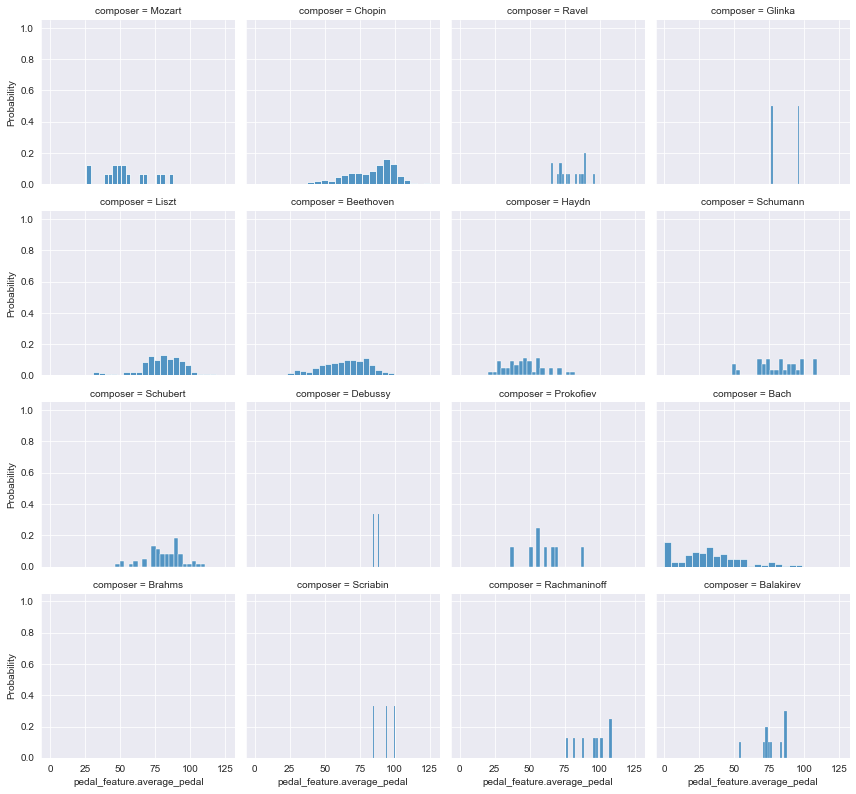

In [8]:
plot_by_dataset(dataset="ASAP", attri=all_features[-2], level="piece")

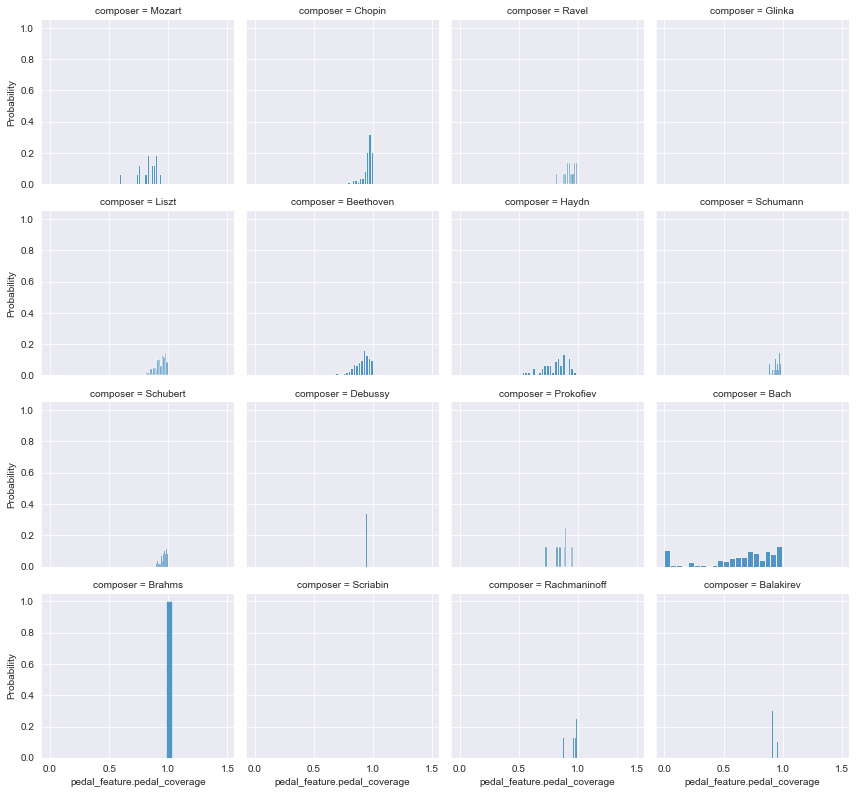

In [9]:
plot_by_dataset(dataset="ASAP", attri=all_features[-1], level="piece")

ASAP 0.8712621331214905


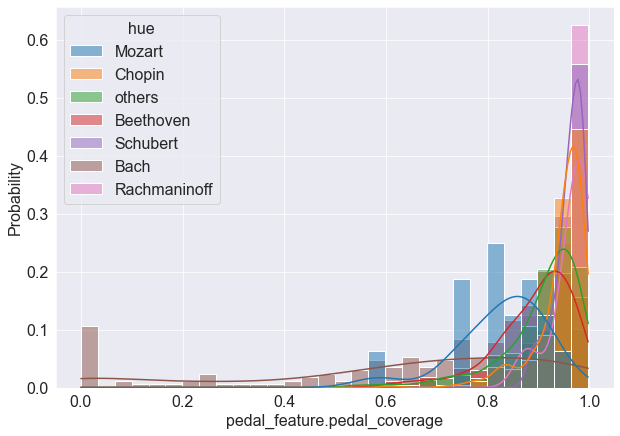

In [57]:
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-1])
plot_datasets(datasets=["ASAP"], attri=all_features[-1], selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 'Schubert', 'Bach'])

ASAP 67.05475616455078


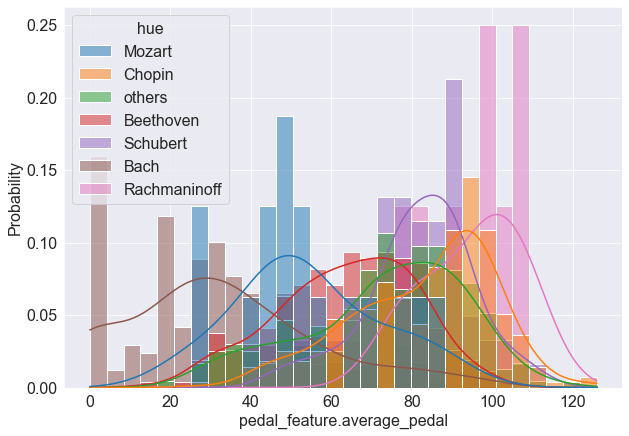

In [62]:
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-2])
# plot_datasets(datasets=["VIENNA422"], attri=all_features[-2])
plot_datasets(datasets=["ASAP"], attri=all_features[-2], selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 'Schubert', 'Bach'])

In [3]:
# get all pedal summarization in ATEPP dataset
import glob
from scipy.integrate import quad
def pedal_feature(performance):
    """
    Compute the pedal features. 

    Repp: Pedal Timing and Tempo in Expressive Piano Performance: A Preliminary Investigation
        How pedal timing adjust to the IOI variations. 

    Parameters
    ----------
    m_score : list
        correspondance between score and performance notes, with score markings. 
    unique_onset_idxs : list
        a list of arrays with the note indexes that have the same onset
    performance: PerformedPart
        The original PerformedPart object
        
    Returns
    -------
    pedal_ : structured array (4, n_notes) with fields
        onset_value [0, 127]: The interpolated pedal value at the onset
        offset_value [0, 127]: The interpolated pedal value at the key offset
        to_prev_release [0, 10]: delta time from note onset to the previous pedal release 'peak'
        to_next_release [0, 10]: delta time from note offset to the next pedal release 'peak'
        average_pedal [0, 127]: integral of the time-pedal curve, divided by duration, piece level (one value)
        pedal_coverage [0, 1]: the percentage of notes being covered by pedal above 
            the threshold (default 10), piece level
    """  
    
    ramp_func, final_time = pedal_ramp(performance.performedparts[0])

    x = np.linspace(0, final_time, 500)
    y = ramp_func(x)

    # average
    res = quad(ramp_func, -np.inf, np.inf)
    average_pedal = (res[0] / final_time) if final_time else 0 
    
    # coverage
    indices_greater_than_10 = np.where(ramp_func(x) > 10)[0]
    step_size = final_time / 500
    continuous_duration = len(indices_greater_than_10) * step_size
    pedal_coverage = (continuous_duration / final_time) if final_time else 0 

    features = rfn.merge_arrays([average_pedal, pedal_coverage], flatten=True, usemask=False)
    return {"features": features}

def pedal_ramp(ppart):
    """Pedal ramp in the same shape as the m_score.

    Returns:
    * pramp : a ramp function that ranges from 0
                  to 127 with the change of sustain pedal
    """
    pedal_controls = ppart.controls

    timepoints = [control['time'] for control in pedal_controls]
    values = [control['value'] for control in pedal_controls]

    if len(timepoints) <= 1: # the case there is no pedal
        timepoints, values = [0, 0], [0, 0]

    agg_ramp_func = interp1d(timepoints, values, bounds_error=False, fill_value=0)

    return agg_ramp_func, timepoints[-1]



alignment_paths = glob.glob(os.path.join(ATEPP_DIR, "**/*_match.txt"), recursive=True)
performance_paths = glob.glob(os.path.join(ATEPP_DIR, "**/*[0-9].mid"), recursive=True)

# for p_path in tqdm(performance_paths):

#     performance = pt.load_performance(p_path)
#     pedal_features = pedal_feature(performance)

#     print(pedal_features)
#     np.save(f"{p_path[:-4]}_perf_features.npy", pedal_features) 
        

  0%|          | 2/11716 [00:00<13:48, 14.14it/s]

{'features': array([(30.84482967, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.4481475, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.55326782, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 6/11716 [00:00<15:04, 12.94it/s]

{'features': array([(43.69191079, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.73125304, 0.814)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.06061887, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 8/11716 [00:00<14:31, 13.44it/s]

{'features': array([(35.54465237, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.08505763, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(36.63824531, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 10/11716 [00:00<14:16, 13.66it/s]

{'features': array([(33.25928674, 0.814)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(37.9796186, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 12/11716 [00:01<18:12, 10.71it/s]

{'features': array([(38.82342243, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 14/11716 [00:01<26:22,  7.39it/s]

{'features': array([(35.517163, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.54447654, 0.818)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 17/11716 [00:01<24:20,  8.01it/s]

{'features': array([(36.10060547, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(27.00641092, 0.862)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(32.8568233, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 19/11716 [00:02<23:46,  8.20it/s]

{'features': array([(24.18759806, 0.836)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(36.29544195, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 20/11716 [00:02<24:52,  7.84it/s]

{'features': array([(40.78260564, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(26.71515466, 0.816)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 23/11716 [00:02<27:11,  7.17it/s]

{'features': array([(28.81496736, 0.838)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(49.88958214, 0.88)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 24/11716 [00:02<29:03,  6.71it/s]

{'features': array([(25.10836608, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 26/11716 [00:03<32:44,  5.95it/s]

{'features': array([(38.3709384, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.71288277, 0.866)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 28/11716 [00:03<31:52,  6.11it/s]

{'features': array([(42.65039591, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.48677327, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 30/11716 [00:03<35:28,  5.49it/s]

{'features': array([(46.63845728, 0.834)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(43.62955854, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 32/11716 [00:04<35:12,  5.53it/s]

{'features': array([(25.56962137, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.6894278, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 33/11716 [00:04<34:47,  5.60it/s]

{'features': array([(22.08544091, 0.848)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 35/11716 [00:04<36:27,  5.34it/s]

{'features': array([(33.73789054, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.51417039, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 37/11716 [00:05<35:55,  5.42it/s]

{'features': array([(33.18701485, 0.852)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(42.40505962, 0.81)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 39/11716 [00:05<35:56,  5.41it/s]

{'features': array([(40.61036776, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(31.09474665, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 41/11716 [00:05<34:54,  5.58it/s]

{'features': array([(28.03903205, 0.818)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(60.60638565, 0.878)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 43/11716 [00:06<37:23,  5.20it/s]

{'features': array([(45.46574406, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.82021441, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 45/11716 [00:06<35:34,  5.47it/s]

{'features': array([(40.42207204, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.5531254, 0.81)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 48/11716 [00:06<24:04,  8.08it/s]

{'features': array([(42.28780122, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.29649204, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(42.11941209, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 52/11716 [00:07<16:37, 11.69it/s]

{'features': array([(26.06471537, 0.744)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(24.04127494, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(30.1908045, 0.784)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(28.73749508, 0.802)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 54/11716 [00:07<15:15, 12.74it/s]

{'features': array([(28.76067224, 0.802)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(25.62146451, 0.796)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(29.67705976, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 56/11716 [00:07<16:15, 11.95it/s]

{'features': array([(36.29785608, 0.834)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(31.60707366, 0.842)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  0%|          | 58/11716 [00:07<19:17, 10.07it/s]

{'features': array([(41.50553915, 0.826)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.96590511, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 61/11716 [00:08<22:30,  8.63it/s]

{'features': array([(28.19336371, 0.82)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.72398665, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 63/11716 [00:08<23:45,  8.17it/s]

{'features': array([(32.89187128, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.78321947, 0.84)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 66/11716 [00:08<20:20,  9.54it/s]

{'features': array([(32.08163135, 0.83)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(40.51064813, 0.87)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.97101308, 0.876)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 69/11716 [00:09<19:15, 10.08it/s]

{'features': array([(36.86269644, 0.856)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(26.45080243, 0.886)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.45264727, 0.854)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 71/11716 [00:09<17:48, 10.90it/s]

{'features': array([(38.21239981, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.51544992, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.62104541, 0.862)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 75/11716 [00:09<16:37, 11.67it/s]

{'features': array([(41.88603624, 0.848)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(72.35074716, 0.88)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(46.8113482, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 77/11716 [00:09<21:58,  8.83it/s]

{'features': array([(35.62972781, 0.832)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(35.80005822, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 79/11716 [00:10<23:31,  8.25it/s]

{'features': array([(33.12793225, 0.838)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(23.66658095, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 81/11716 [00:10<25:40,  7.55it/s]

{'features': array([(39.82822633, 0.844)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.80484727, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 83/11716 [00:10<29:27,  6.58it/s]

{'features': array([(35.49642938, 0.864)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(38.91153225, 0.824)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 85/11716 [00:11<28:59,  6.69it/s]

{'features': array([(36.39959603, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(41.62640999, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 88/11716 [00:11<22:42,  8.53it/s]

{'features': array([(39.18420133, 0.828)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(33.55588393, 0.856)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(39.69486202, 0.85)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


  1%|          | 90/11716 [00:11<25:05,  7.72it/s]

{'features': array([(37.64578056, 0.822)], dtype=[('f0', '<f8'), ('f1', '<f8')])}
{'features': array([(37.92806689, 0.846)], dtype=[('f0', '<f8'), ('f1', '<f8')])}


KeyboardInterrupt: 

In [ ]:
pf, meta_dict = load_dataset_pf(datasets=['ATEPP'], return_metadata=True)

ATEPP 33.297072360184245


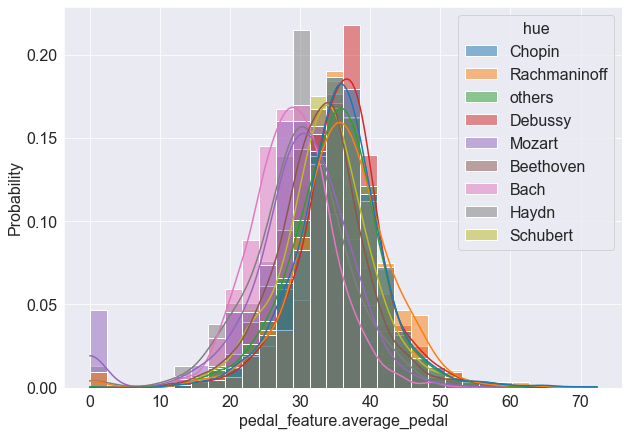

In [76]:
plot_datasets(datasets=["ATEPP"], attri=all_features[-2], 
              selected_hue=['Mozart', 'Chopin', 'Beethoven', 'Rachmaninoff', 
                            'Schubert', 'Bach', 'Debussy', 'Haydn'],
              pf=pf,
              meta_dict=meta_dict
              )

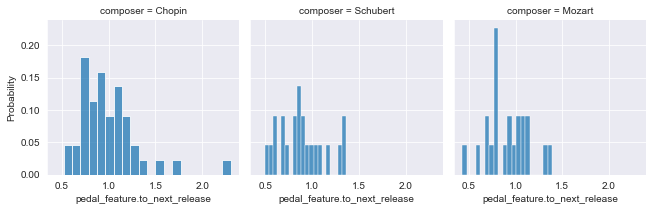

In [ ]:
plot_by_dataset(dataset="VIENNA422", attri=all_features[12], level="piece")

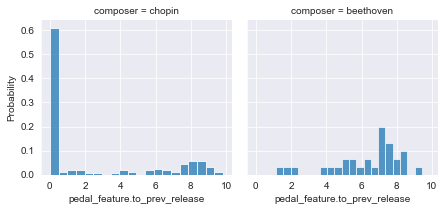

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[11], level="piece")

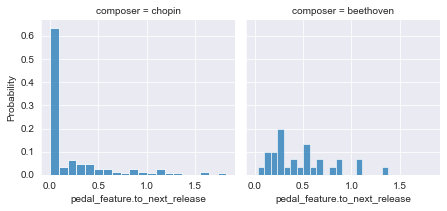

In [ ]:
plot_by_dataset(dataset="BMZ", attri=all_features[12], level="piece")

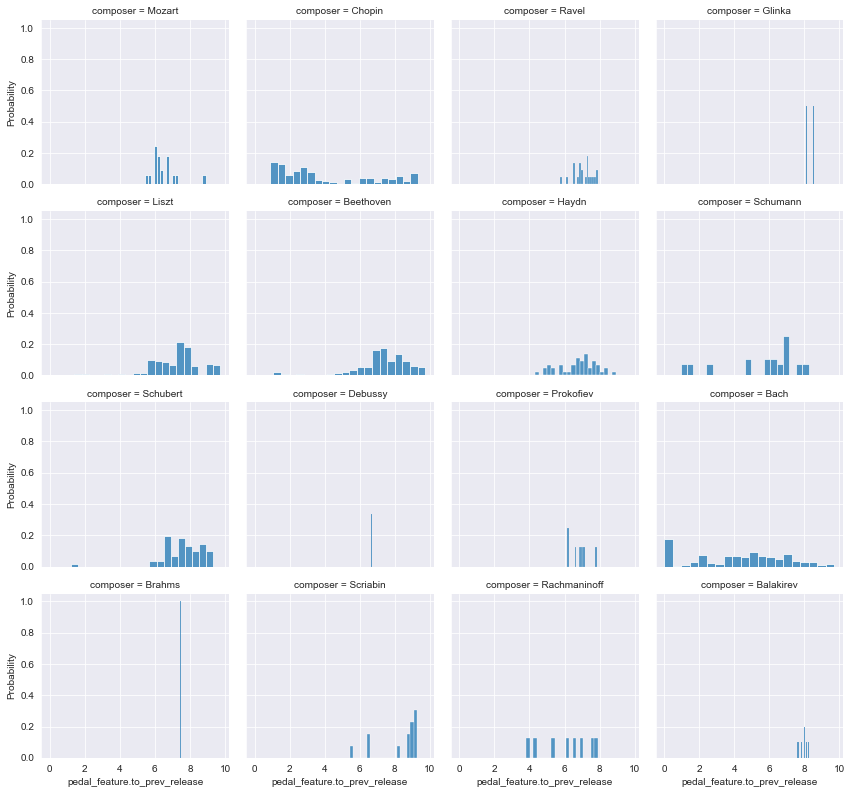

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[11], level="piece")

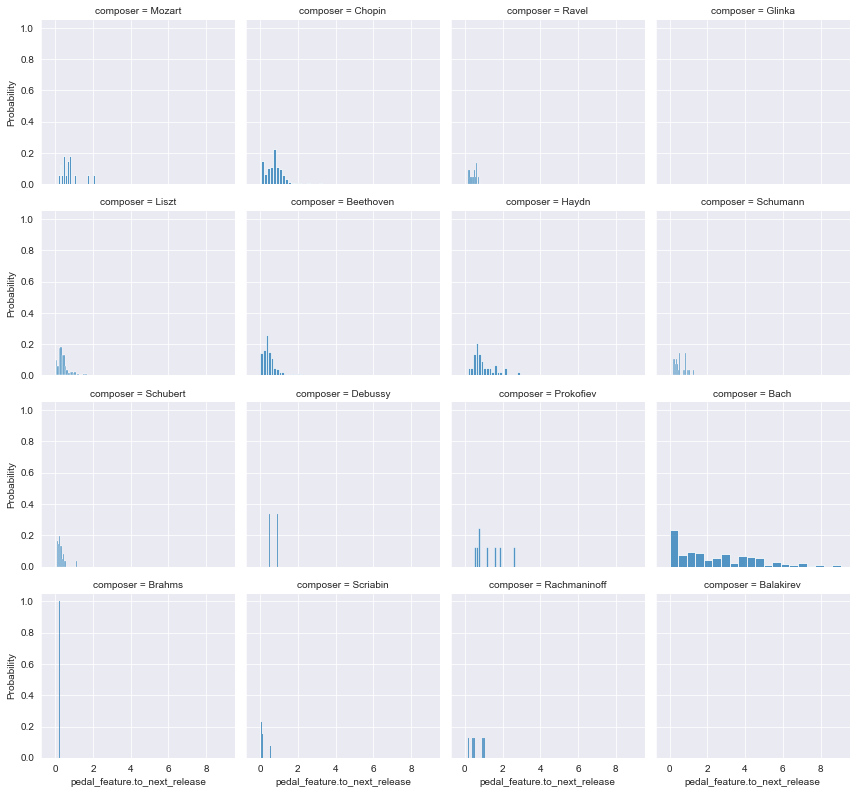

In [ ]:
plot_by_dataset(dataset="ASAP", attri=all_features[12], level="piece")

### Articulation: Overall articulation analysis

#### Two consonant tones overlapped more than two dissonant tones?

#### KOT breakdown by the score articulation marking

In [3]:
x_total, y_total, z_total, k_total, x_class = [], [], [], [], []

# performance_paths = glob.glob(os.path.join(VIENNA_PERFORMANCE_DIR, "*[!e].mid"))
# alignment_paths = [(VIENNA_MATCH_DIR + pp.split("/")[-1][:-4] + ".match") for pp in performance_paths]
# score_paths = [(VIENNA_MUSICXML_DIR + pp.split("/")[-1][:-8] + ".musicxml") for pp in performance_paths]
# # performance_paths = [None] * len(alignment_paths) # don't use the given performance, use the aligned.

for dataset in ['ASAP', 'VIENNA422', 'BMZ']:
    alignment_paths, score_paths, performance_paths = process_dataset_pf(datasets=[dataset], 
                                                                         only_return_paths=True)
    alignment_paths = alignment_paths
    for s_path, p_path, a_path in tqdm(zip(score_paths, performance_paths, alignment_paths)):
        try:
            score = pt.load_musicxml(s_path)
            if a_path[-3:] == "tsv":
                alignment = pt.io.importparangonada.load_alignment_from_ASAP(a_path)
                performance = pt.load_performance(p_path)
            else:
                performance, alignment = pt.load_match(a_path)

            if dataset == "ASAP" or dataset == 'BMZ': 
                for a in alignment:
                    if 'score_id' in a and  "-" in a['score_id']:
                        a['score_id'] = a['score_id'][:-2]
                # score = pt.score.unfold_part_maximal(pt.score.merge_parts(score.parts)) 

            pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, 
                                                                    feature_functions=['articulation_feature'],
                                                                    return_articulation_mask=True)
            x = pd.DataFrame(pf['articulation_feature.kor'])
            x['dataset'] = dataset
            x_total.append(x)
            y_total.append(pd.DataFrame(res['articulation_mask']))
            z_total.append(pd.DataFrame(res['con_mask']))
            k_total.append(pd.DataFrame(res['no_kor_mask']))
        except Exception as e:
            print(a_path)
            print(e)
        
x_total, y_total, z_total, k_total = pd.concat(x_total), pd.concat(y_total), pd.concat(z_total), pd.concat(k_total)
x_legato = x_total[y_total['legato']]
x_staccato = x_total[y_total['staccato']]
x_repeated = x_total[y_total['repeated']]
x_data = pd.concat([x_legato, x_staccato, x_repeated])
x_data['label'] = (['legato'] * len(x_legato) + 
                   ['staccato'] * len(x_staccato) + 
                   ['repeated'] * len(x_repeated))

x_total = x_total[~np.array(k_total)]
z_total = z_total[~np.array(k_total)]

168it [13:14,  4.98s/it]

../Datasets/asap-dataset-alignment/Chopin/Sonata_2/3rd/KaszoS15_note_alignments/note_alignment.tsv
[Errno 2] No such file or directory: '../Datasets/asap-dataset-alignment/Chopin/Sonata_2/3rd/KaszoS15_note_alignments/note_alignment.tsv'


451it [1:53:16,  7.75s/it] 

../Datasets/asap-dataset-alignment/Beethoven/Piano_Sonatas/29-4/DANILO01_note_alignments/note_alignment.tsv
[Errno 2] No such file or directory: '../Datasets/asap-dataset-alignment/Beethoven/Piano_Sonatas/29-4/DANILO01_note_alignments/note_alignment.tsv'


692it [8:31:09,  1.82s/it]  

../Datasets/asap-dataset-alignment/Beethoven/Piano_Sonatas/17-2/KaszoS10_note_alignments/note_alignment.tsv
[Errno 2] No such file or directory: '../Datasets/asap-dataset-alignment/Beethoven/Piano_Sonatas/17-2/KaszoS10_note_alignments/note_alignment.tsv'


844it [8:57:02, 56.17s/it] 

../Datasets/asap-dataset-alignment/Schubert/Impromptu_op142/1/Lisiecki10M_note_alignments/note_alignment.tsv
[Errno 2] No such file or directory: '../Datasets/asap-dataset-alignment/Schubert/Impromptu_op142/1/Lisiecki10M_note_alignments/note_alignment.tsv'


1067it [9:56:25, 33.54s/it] 
88it [00:30,  2.89it/s]
51it [06:16,  7.38s/it]


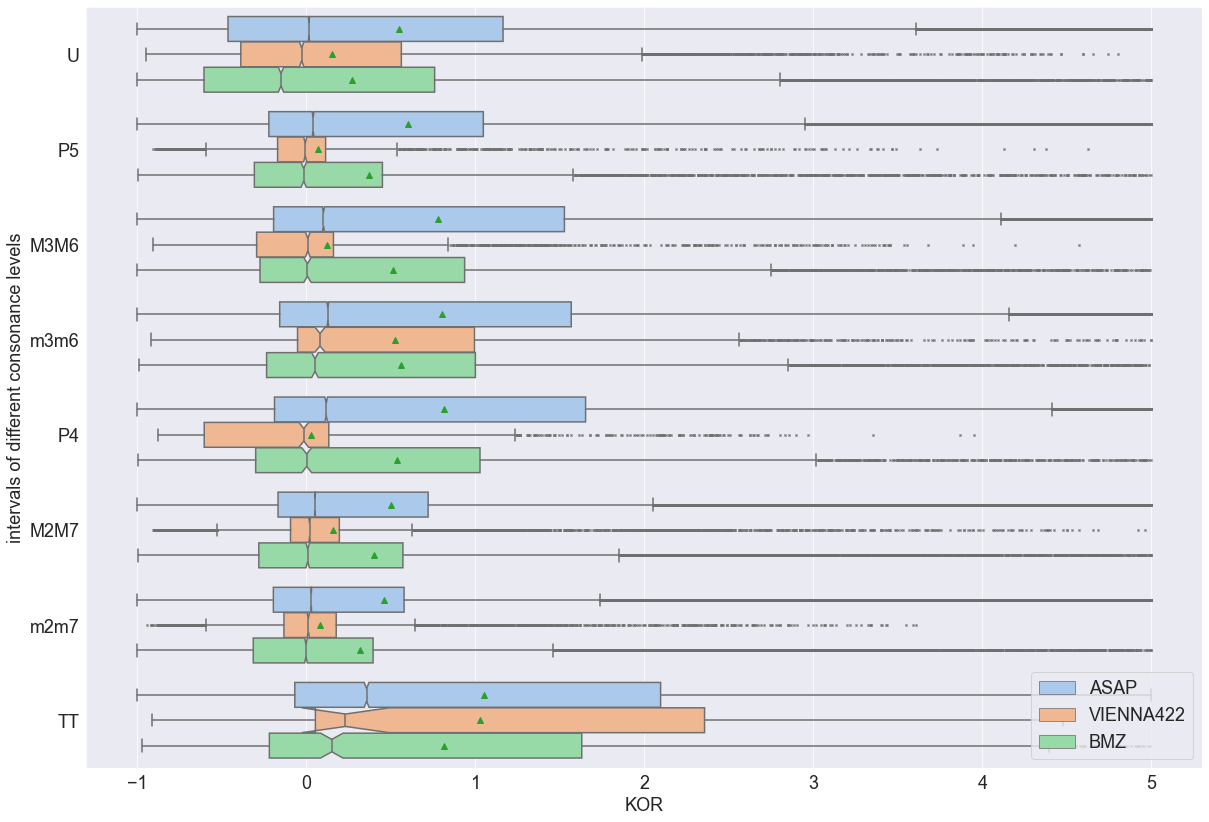

In [22]:
x_total['consonance'] = z_total
from copy import deepcopy
x_total_ = deepcopy(x_total)
x_total_ = x_total_.reset_index().drop(columns=['index'])


x_total_ = x_total_[(x_total_[0] != -1) & (x_total_[0] != 5) ]
plt.rcParams['figure.figsize'] = [20, 14]
plt.rcParams['font.size'] = 18
sns.set_style('darkgrid')
x_total_ = x_total_[x_total_['consonance'] != 'Undefined']
sns.boxplot(
    data=x_total_,
    x=0, y='consonance', hue='dataset',
    notch=True,
    order=['U', "P5",  'M3M6', 'm3m6', 'P4', 'M2M7', 'm2m7', 'TT'],
    flierprops={"marker": "x"},
    fliersize=2,
    palette="pastel",
    showmeans=True
    # palette="ch:rot=-.25,hue=1,light=.75"
    # marginal_kws={'common_norm':False}
)
# plt.xlim(-1, 5)
plt.xlabel("KOR")
plt.ylabel("intervals of different consonance levels")
plt.legend(loc='lower right')

In [27]:
dataset = 'ASAP'
interval = 'U'
print(np.array(x_total_[(x_total_['dataset'] == dataset) & (x_total_['consonance'] == interval)][0]).mean(), np.array(x_total_[(x_total_['dataset'] == dataset) & (x_total_['consonance'] == interval)][0]).std())


0.55024004 1.3653412


Text(0.5, 0, 'BMZ')

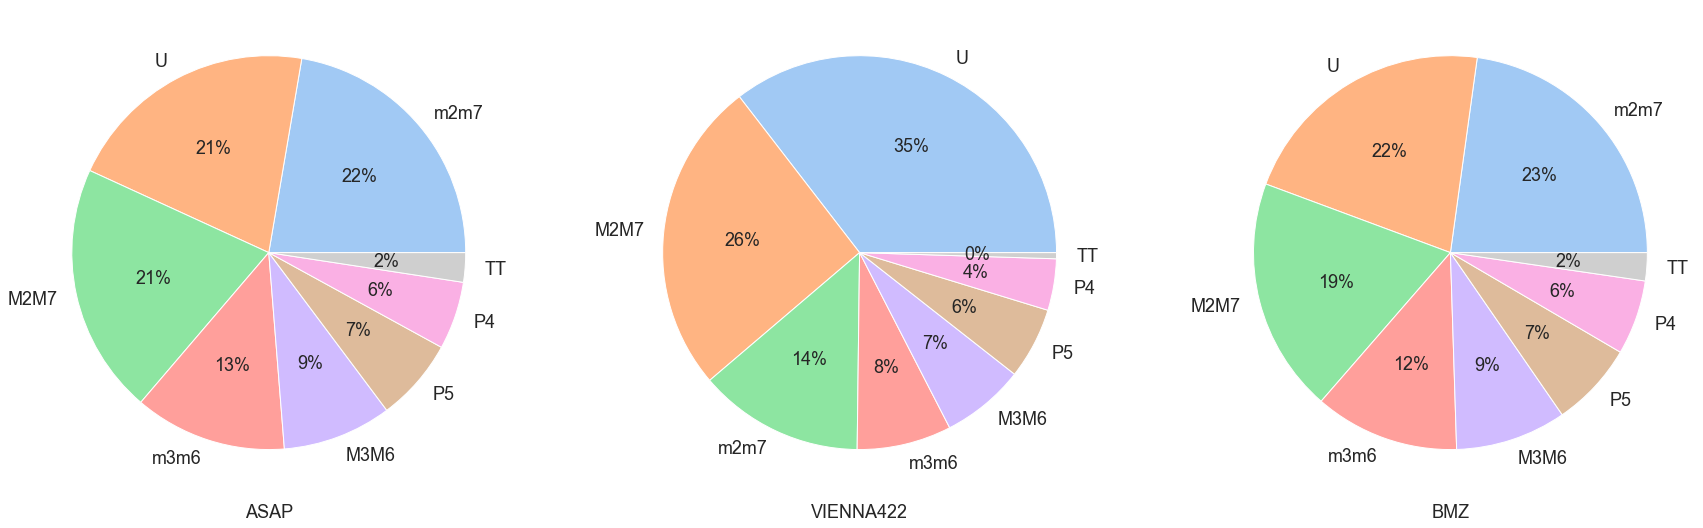

In [46]:
vc0, vc1, vc2 = x_total_[x_total_['dataset'] == 'ASAP']['consonance'].value_counts(), x_total_[x_total_['dataset'] == 'VIENNA422']['consonance'].value_counts(), x_total_[x_total_['dataset'] == 'BMZ']['consonance'].value_counts()
colors = sns.color_palette('pastel')
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].pie(vc0.values, labels = vc0.index, colors = colors, autopct='%.0f%%')
ax[1].pie(vc1.values, labels = vc1.index, colors = colors, autopct='%.0f%%')
ax[2].pie(vc2.values, labels = vc2.index, colors = colors, autopct='%.0f%%')
ax[0].set_xlabel('ASAP')
ax[1].set_xlabel('VIENNA422')
ax[2].set_xlabel('BMZ')

In [2]:
score_path = '/Users/huanzhang/01Acdemics/PhD/Research/Datasets/asap-dataset-alignment/Brahms/Six_Pieces_op_118/2/xml_score.musicxml'
score = pt.score.unfold_part_maximal(pt.score.merge_parts(pt.load_musicxml(score_path).parts)) 
alignment = pt.io.importparangonada.load_alignment_from_ASAP('/Users/huanzhang/01Acdemics/PhD/Research/Datasets/asap-dataset-alignment/Brahms/Six_Pieces_op_118/2/Shilyaev03_note_alignments/note_alignment.tsv')
performance = pt.load_performance('/Users/huanzhang/01Acdemics/PhD/Research/Datasets/asap-dataset-alignment/Brahms/Six_Pieces_op_118/2/Shilyaev03.mid')

pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, 
                                                        feature_functions=['articulation_feature'],
                                                        return_articulation_mask=True)
x = pd.DataFrame(pf['articulation_feature.kor'])
con_mask = pd.DataFrame(res['con_mask'])
no_kor_mask = res['no_kor_mask']

sns.set_style('darkgrid')
data = x[~no_kor_mask]
data['consonance'] = con_mask[~no_kor_mask]
data = data[data['consonance'] != 'Undefined']
data['dataset'] = "ASAP"
data['dataset'][:500] = "VIENNA422"
sns.boxplot(
    data=data,
    x=0, y='consonance', hue='dataset',
    # palette="ch:rot=-.25,hue=1,light=.75"
    # marginal_kws={'common_norm':False}
)

NameError: name 'pt' is not defined

Text(0, 0.5, '')

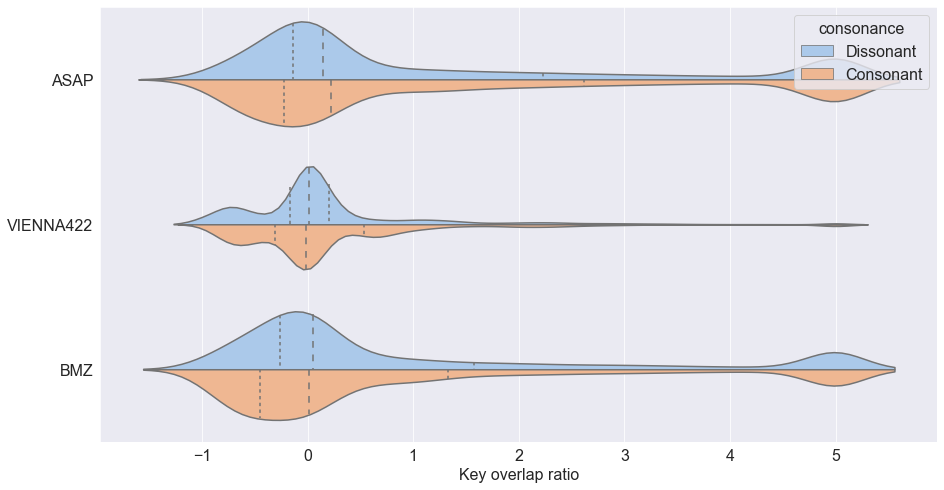

In [33]:
plt.rcParams['font.size'] = 16
x_data_plot = x_data[x_data['label'] != 'repeated']
plt.rcParams['figure.figsize'] = [15, 8]
sns.set_style("darkgrid")
sns.violinplot(data=x_total_, x=0, y='dataset', hue='consonance', bw=0.15, inner='quartile', split=True, palette="pastel",)
# sns.violinplot(data=x_data_plot, x=0, y='dataset', hue='label', bw=0.15, inner='quartile', split=True, palette="pastel",)
# sns.violinplot(data=x_data, x='dataset', y=0, hue='label', bw=0.15, inner='quartile', palette="pastel",)

# plt.ylim((0, 3))
# plt.yticks(np.arange(-1.6, 5.5, 0.3))
plt.xlabel("Key overlap ratio")
plt.ylabel("")

## Timing

### Are local timing patterns preserved in different tempo conditions?

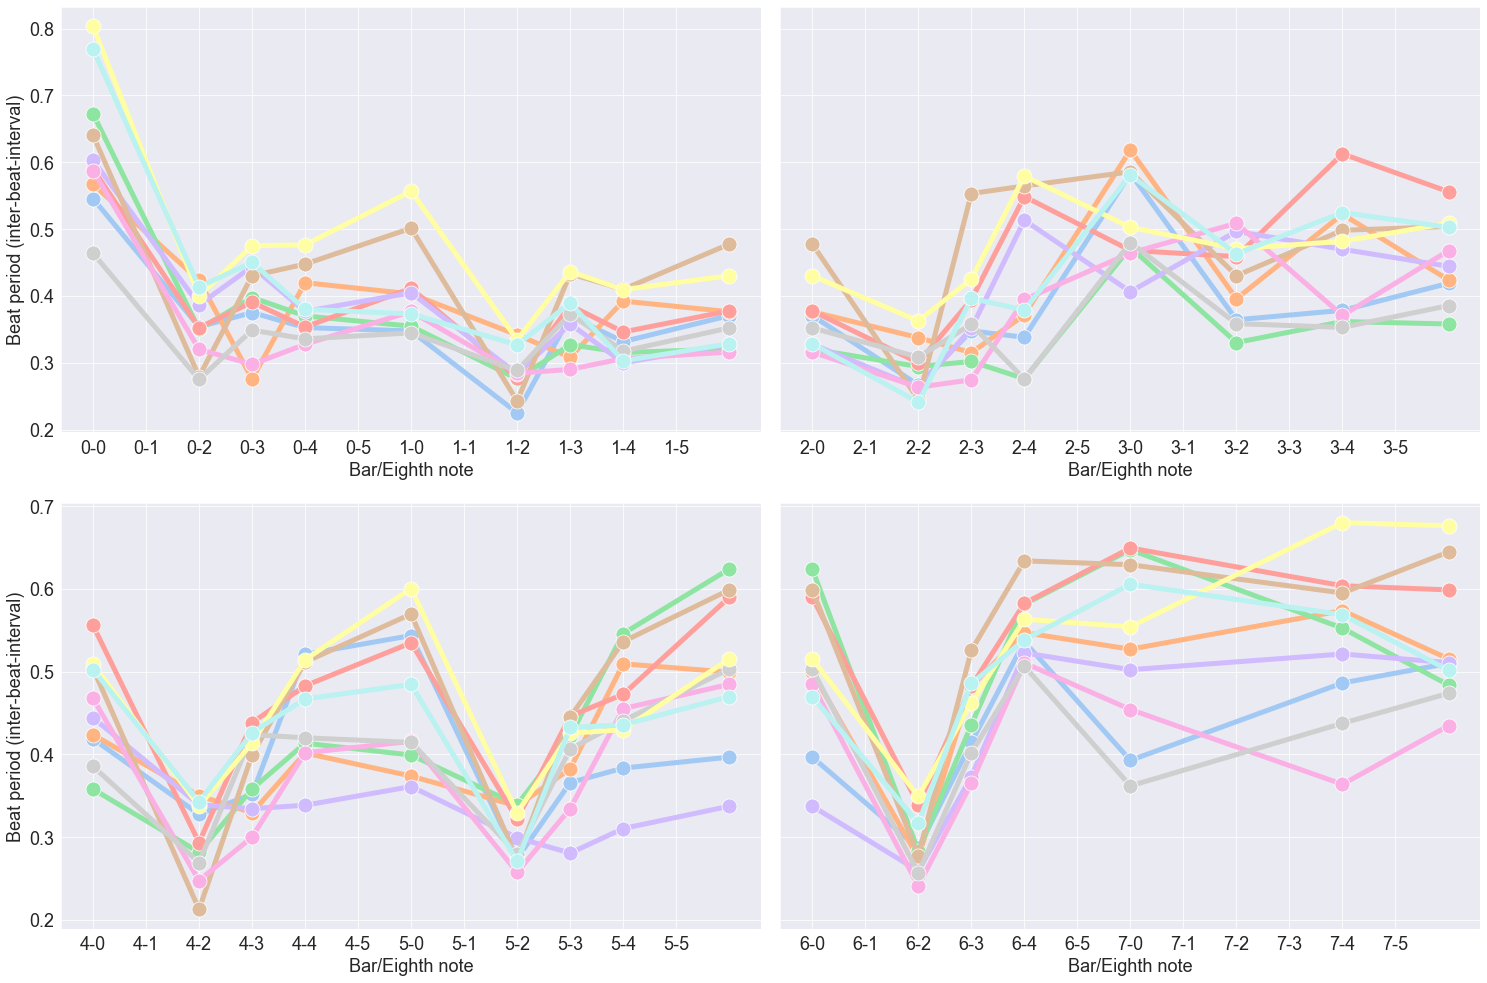

In [85]:
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 18

names = ['Schubert_D783_no15', 'Mozart_K331_1st-mov', 'Chopin_op38', 'Chopin_op10_no3']

score = pt.load_musicxml("../Datasets/vienna4x22/musicxml/Schubert_D783_no15.musicxml")

fig, axes = plt.subplots(2, 2, figsize=(21, 14), sharey='row')

sns.set_style("darkgrid")
colors = sns.color_palette("pastel")
# colors = sns.color_palette("blend:#7AB,#EDA", as_cmap=True)

window = 6
eighth_per_bar = 6

for idx, pianist in enumerate(range(1, 11)):
    pianist = str(pianist).zfill(2)
    performance = pt.load_performance(f"../Datasets/vienna4x22/midi/Schubert_D783_no15_p{pianist}.mid")
    performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/Schubert_D783_no15_p{pianist}.match")

    pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
    unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
    parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
    x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
    y = parameters['beat_period'][[idxs[0] for idxs in unique_onset_idxs]]
    
    for i in range(4):
        start = i * window
        end = start + window
        mask = (x >= start) & (x <= end)
        sns.lineplot(x=x[mask], y=y[mask], color=colors[idx], marker='o', markersize=15, ax=axes.flatten()[i])
        axes.flatten()[i].set_xticks(np.arange(start, end, 0.5), [f"{int(x/eighth_per_bar+i*window/eighth_per_bar*2)}-{int(x%eighth_per_bar)}" for x in np.arange(window * 2)])
        axes.flatten()[i].set_xlabel("Bar/Eighth note")
        axes.flatten()[i].set_ylabel("Beat period (inter-beat-interval)")

plt.tight_layout()
# axes.flatten()[0].legend()
# plt.legend()

120it [01:41,  1.19it/s]


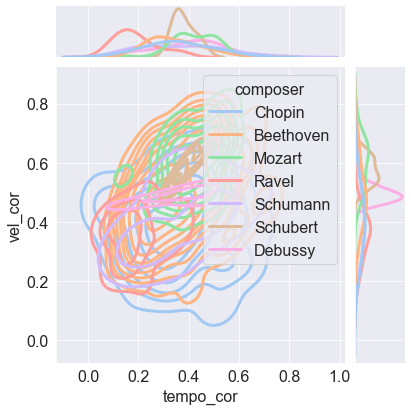

In [80]:

all_composer_unique = np.unique([aod.split('/')[0] for aod in atepp_overlap_dirs])
all_tempo_cor, all_vel_cor, all_composer = [], [], []
for dir_idx, dir in tqdm(enumerate(atepp_overlap_dirs[:120])): 
    pf_feat_dirs = glob.glob(f"{ATEPP_DIR}/{dir}/**/*[!_].npy", recursive=True)
    score = glob.glob(f"{ATEPP_DIR}/{dir}/**/*.*l", recursive=True)[0]
    try:
        score = pt.load_musicxml(score, force_note_ids='keep')
        score_x = np.unique(score.note_array()['onset_beat'])
    except:
        continue
    
    N_windows = int(score.note_array()['onset_beat'].max() / window)      
    bp_all = [[] for _ in range(N_windows)]
    vel_all = [[] for _ in range(N_windows)]

    for pf_feat_dir in pf_feat_dirs:
        pf_feat = np.load(pf_feat_dir, allow_pickle=True)
        res = np.load(f"{pf_feat_dir[:-4]}_res_.npy", allow_pickle=True).item()
        unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
        x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
        try:
            y = pf_feat['beat_period'][[idxs[0] for idxs in unique_onset_idxs]]
        except:
            continue
        yfunc = interp1d(x, y,fill_value="extrapolate")
        y_ = 60 / yfunc(score_x) 
        z = pf_feat['velocity'][[idxs[0] for idxs in unique_onset_idxs]]
        zfunc = interp1d(x, z,fill_value="extrapolate")
        z_ = zfunc(score_x)
        
        for i in range(N_windows):
            start = i * window
            end = start + window
            mask = (score_x >= start) & (score_x <= end)
            bp_all[i].append(y_[mask])
            vel_all[i].append(z_[mask])

    avg_range, tempo_cor, vel_cor = [], [], []
    for idx, group in enumerate(bp_all):
        try:
            stackgroup = np.stack(group)
        except:
            # print(f"group {idx} not aligned")
            continue
        
        try:
            tempo_cor.append(np.round(np.corrcoef(stackgroup)[~np.eye(len(stackgroup), dtype=bool)].mean(), 2))
        except:
            continue
        avg_range.append(np.around(np.ptp(stackgroup.mean(1)), 2))
        vel_cor.append(np.round(np.corrcoef(np.stack(vel_all[idx]))[~np.eye(len(stackgroup), dtype=bool)].mean(), 2))


    tempo_cor = np.array(tempo_cor)
    vel_cor = np.array(vel_cor)
    N = int(len(tempo_cor) / 5)+1
    arr = np.nanmean(np.pad(tempo_cor.astype(float), (0, N - tempo_cor.size%N), mode='constant', constant_values=np.NaN).reshape(-1, N), axis=1)
    all_tempo_cor.extend(arr)
    all_vel_cor.extend(np.nanmean(np.pad(vel_cor.astype(float), (0, N - vel_cor.size%N), mode='constant', constant_values=np.NaN).reshape(-1, N), axis=1))
    all_composer.extend([dir.split("/")[0].split("_")[-1]] * len(arr))

data = pd.DataFrame({"tempo_cor": all_tempo_cor, "vel_cor": all_vel_cor, "composer": all_composer})
g0 = sns.jointplot(
    data=data, 
    x='tempo_cor', y='vel_cor', hue="composer", kind='kde', palette="pastel", marginal_kws={'common_norm':False})

plt.rcParams['lines.linewidth'] = 3


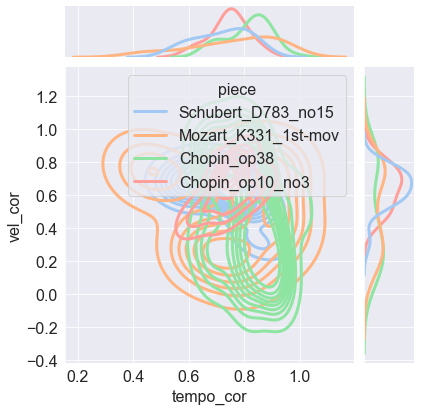

In [81]:
names = ['Schubert_D783_no15', 'Mozart_K331_1st-mov', 'Chopin_op38', 'Chopin_op10_no3'] # ()

all_tempo_cor, all_vel_cor, all_piece = [], [], []
for piece_idx, name in enumerate(names):
    score = pt.load_musicxml(f"../Datasets/vienna4x22/musicxml/{name}.musicxml")
    score_x = np.unique(score.note_array()['onset_beat'])

    window = 6          # number of beats
    eighth_per_bar = 6  # 3/4 meter
    N_windows = int(score.note_array()['onset_beat'].max() / window)      
    bp_all = [[] for _ in range(N_windows)]
    vel_all = [[] for _ in range(N_windows)]

    for idx, pianist in enumerate(range(1, 22)):
        pianist = str(pianist).zfill(2)
        performance = pt.load_performance(f"../Datasets/vienna4x22/midi/{name}_p{pianist}.mid")
        performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/{name}_p{pianist}.match")

        pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
        unique_onset_idxs, m_score = res['unique_onset_idxs'], res['m_score']
        parameters, snote_ids = pt.musicanalysis.encode_performance(score, performance, alignment)
        x = m_score['onset'][[idxs[0] for idxs in unique_onset_idxs]]
        y = parameters['beat_period'][[idxs[0] for idxs in unique_onset_idxs]]
        yfunc = interp1d(x, y,fill_value="extrapolate")
        y_ = 60 / yfunc(score_x)
        z = parameters['velocity'][[idxs[0] for idxs in unique_onset_idxs]]
        zfunc = interp1d(x, z,fill_value="extrapolate")
        z_ = zfunc(score_x)

        for i in range(N_windows):
            start = i * window
            end = start + window
            mask = (score_x >= start) & (score_x <= end)
            bp_all[i].append(y_[mask])
            vel_all[i].append(z_[mask])

    avg_range, tempo_cor, vel_cor = [], [], []
    for idx, group in enumerate(bp_all):
        try:
            stackgroup = np.stack(group)
        except:
            print(f"group {idx} not aligned")
            continue
        
        avg_range.append(np.around(np.ptp(stackgroup.mean(1)), 2))
        tempo_cor.append(np.round(np.corrcoef(stackgroup)[~np.eye(21, dtype=bool)].mean(), 2))
        vel_cor.append(np.round(np.corrcoef(np.stack(vel_all[idx]))[~np.eye(21, dtype=bool)].mean(), 2))
        # print(f"avg_range: {avg_range}; cor: {cor}")

    # sns.scatterplot(x=tempo_cor, y=vel_cor, s=80, color=colors[piece_idx], label=name, ax=axes[0])
    all_tempo_cor.extend(tempo_cor)
    all_vel_cor.extend(vel_cor)
    all_piece.extend([name] * len(tempo_cor))

data = pd.DataFrame({"tempo_cor": all_tempo_cor, "vel_cor": all_vel_cor, "piece": all_piece})

g1 = sns.jointplot(
    data=data, 
    x='tempo_cor', y='vel_cor', hue="piece", kind='kde', palette="pastel", marginal_kws={'common_norm':False})




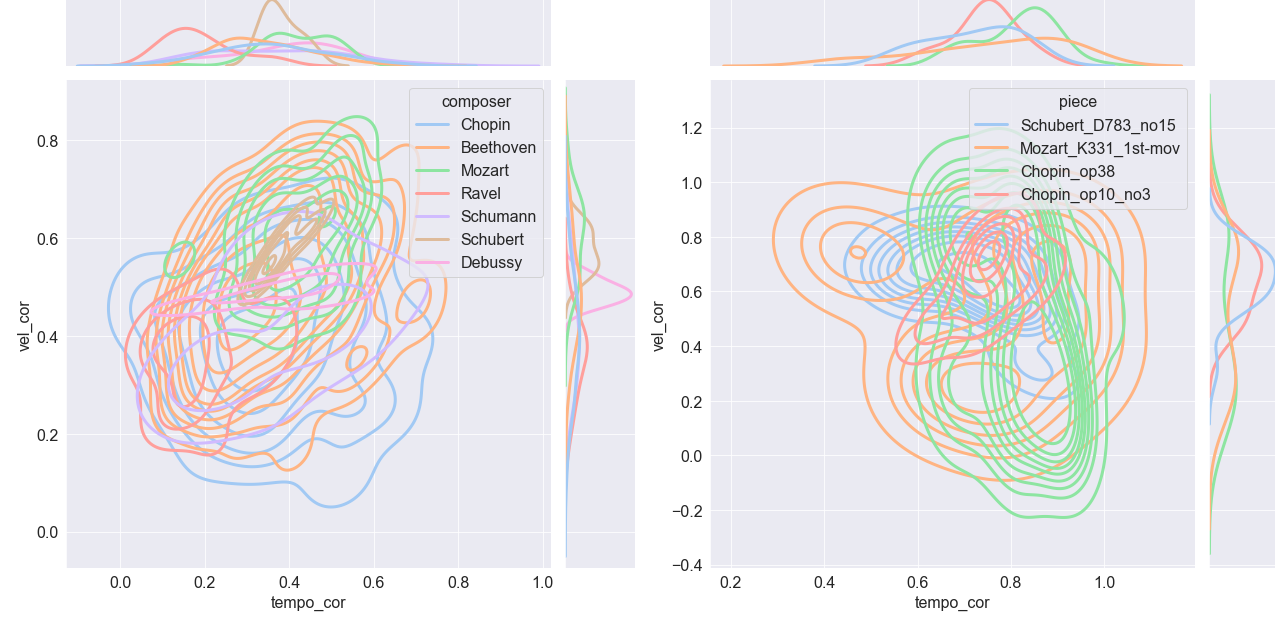

Text(755.6727272727271, 0.5, 'Average intra-performer velocity correlation')

In [82]:
fig = plt.figure(figsize=(18,9))
gs = gridspec.GridSpec(1, 2)
mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

gs.tight_layout(fig)
plt.show()

# plt.legend()
axes[0].set_xlabel("Average intra-performer tempo correlation")
axes[0].set_ylabel("Average intra-performer velocity correlation")
axes[1].set_xlabel("Average intra-performer tempo correlation")
axes[1].set_ylabel("Average intra-performer velocity correlation")

In [5]:
def get_atepp_overlap(): 
    """get the atepp subset with pieces of more than 8+ performances
    Returns: 
    """
    atepp_meta = pd.read_csv(ATEPP_META_DIR)
    score_groups = atepp_meta.groupby(['score_path']).count().sort_values(['midi_path'], ascending=False)
    selected_scores = score_groups.iloc[4:216]
    selected_score_folders = ["/".join(score_entry.name.split("/")[:-1]) for _, score_entry in selected_scores.iterrows()]

    return selected_score_folders

atepp_overlap_dirs = get_atepp_overlap()

In [223]:
from scipy.stats import f_oneway
import pandas as pd
all_tempos, all_asyncs, all_kors, all_labels, all_labels_, dataset, dataset_ = [], [], [], [], [], [], []
names = ['Schubert_D783_no15', 'Mozart_K331_1st-mov', 'Chopin_op38', 'Chopin_op10_no3'] # ()


# for piece_idx, name in enumerate(names):
#     score = pt.load_musicxml(f"../Datasets/vienna4x22/musicxml/{name}.musicxml")
#     tempos, asyncs, kors = [], [], []
#     for idx, pianist in enumerate(range(1, 22)):
#         pianist = str(pianist).zfill(2)
#         performance = pt.load_performance(f"../Datasets/vienna4x22/midi/{name}_p{pianist}.mid")
#         performance, alignment = pt.load_match(f"../Datasets/vienna4x22/match/{name}_p{pianist}.match")

#         pf, res = pt.musicanalysis.compute_performance_features(score, performance, alignment, feature_functions="all")
#         parameters, _ = pt.musicanalysis.encode_performance(score, performance, alignment)
#         tempos.append(60 / parameters['beat_period'].mean())
#         asyncs.append(pf['asynchrony_feature.delta'].mean()) # maybe not mean?
#         kors.append(pf['articulation_feature.kor'].mean())


#     N = len(tempos)
#     sort_index = np.argsort(tempos)
#     tempos, asyncs, kors = np.array(tempos)[sort_index], np.array(asyncs)[sort_index], np.array(kors)[sort_index]
#     low_tempo, mid_tempo, high_tempo = tempos[:int(N/3)], tempos[int(N/3):int(N*2/3)], tempos[int(N*2/3):]
#     low_tempo_async, mid_tempo_async, high_tempo_async = asyncs[:int(N/3)], asyncs[int(N/3):int(N*2/3)], asyncs[int(N*2/3):]
#     low_tempo_kor, mid_tempo_kor, high_tempo_kor = kors[:int(N/3)], kors[int(N/3):int(N*2/3)], kors[int(N*2/3):]

#     F, p = f_oneway(low_tempo_async, mid_tempo_async, high_tempo_async)
#     print("async", F, p)
#     all_asyncs.extend(asyncs)
#     all_labels.extend(["slow"] * int(N/3) + ["medium"] * int(N/3) + ["fast"] * (N - int(N/3)*2))
#     dataset.extend(['VIENNA422'] * N)
#     F, p = f_oneway(low_tempo_kor, mid_tempo_kor, high_tempo_kor)
#     print("kor",F, p)
#     all_kors.extend(kors)
#     all_labels_.extend(["slow"] * int(N/3) + ["medium"] * int(N/3) + ["fast"] * (N - int(N/3)*2))
#     dataset_.extend(['VIENNA422'] * N)
        

for idx, dir in tqdm(enumerate(atepp_overlap_dirs)): # 5036 pieces, 276 dir 
    if not "Mephisto" in dir:
        continue
    pf_feat_dirs = glob.glob(f"{ATEPP_DIR}/{dir}/**/*[!_].npy", recursive=True)
    tempos, asyncs, kors = [], [], []
    for pf_feat_dir in pf_feat_dirs:
        pf_feat = np.load(pf_feat_dir)
        try:
            tempos.append(60 / pf_feat['beat_period'].mean())
            asyncs.append(pf_feat['asynchrony_feature.delta'].mean()) 
            kors.append(pf_feat['articulation_feature.kor'].mean())
        except:
            continue

    N = len(tempos)
    sort_index = np.argsort(tempos)
    tempos, asyncs, kors = np.array(tempos)[sort_index], np.array(asyncs)[sort_index], np.array(kors)[sort_index]
    low_tempo, mid_tempo, high_tempo = tempos[:int(N/3)], tempos[int(N/3):int(N*2/3)], tempos[int(N*2/3):]
    low_tempo_async, mid_tempo_async, high_tempo_async = asyncs[:int(N/3)], asyncs[int(N/3):int(N*2/3)], asyncs[int(N*2/3):]
    low_tempo_kor, mid_tempo_kor, high_tempo_kor = kors[:int(N/3)], kors[int(N/3):int(N*2/3)], kors[int(N*2/3):]

    F, p = f_oneway(low_tempo_async, mid_tempo_async, high_tempo_async)
    if p < 0.05:
        # print(dir, round(F, 2), p, len(pf_feat_dirs))
        # all_tempos.extend(tempos)
        all_asyncs.extend(asyncs)
        all_labels.extend(["slow"] * int(N/3) + ["medium"] * int(N/3) + ["fast"] * (N - int(N/3)*2))
        dataset.extend(['ATEPP'] * N)
        meta_csv = pd.read_csv(ATEPP_DATA_CSV)
        midi_ids = [path.split("/")[-2] for path in np.array(pf_feat_dirs)[sort_index]]
        performers = [meta_csv[meta_csv['midi_path'].str.contains(id)]['artist'].item() for id in midi_ids]
        data = pd.DataFrame({'performers': performers, "tempo (bpm)": tempos, "asynchrony (ms)": asyncs})
        plt.rcParams['figure.figsize'] = (13, 9) 
        plt.rcParams['font.size'] = 16
        sns.scatterplot(data=data, x='tempo (bpm)', y='asynchrony (ms)', hue='performers', palette='pastel', s=200)
    F, p = f_oneway(low_tempo_kor, mid_tempo_kor, high_tempo_kor)
    if p < 0.05:
        print(dir, round(F, 2), round(p, 2), len(pf_feat_dirs))
        # all_tempos.extend(tempos)
        all_kors.extend(kors)
        all_labels_.extend(["slow"] * int(N/3) + ["medium"] * int(N/3) + ["fast"] * (N - int(N/3)*2))
        dataset_.extend(['ATEPP'] * N)       

data_async = pd.DataFrame({"async": all_asyncs,  "label": all_labels, 'dataset': dataset})
data_kor = pd.DataFrame({"kor": all_kors, "label": all_labels_, 'dataset': dataset_})


100%|██████████| 212/212 [00:00<00:00, 735.14it/s]


4502

### Effect of tempo on asynchrony

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2)
axes[0].set_ylim(0, 0.12)
sns.boxplot(data=data_async, x='label', y='async', hue='dataset', ax=axes[0], showmeans=True, palette='pastel')
axes[0].set_ylabel("asynchrony.delta")
sns.boxplot(data=data_kor, x='label', y='kor', hue='dataset', ax=axes[1], showmeans=True, palette='pastel')
axes[0].set_xlabel("")
axes[1].set_xlabel("")
plt.tight_layout()